## Assignment:

- In this assignment, you'll be working with the heart disease dataset from the UC Irvine Machine Learning Repository.
- Here, X will be your features and in y we hold the labels. If y is equal to 1, then it indicates that the corresponding patient has heart disease and if y is equal to 0, then the patient doesn't have heart disease.

- Create a k-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters. Note that in this case, we actually know the correct number of clusters in the data which is two. But, you'll test whether k-means will assign observations as we expect it to do. Since k-means is an unsupervised learning algorithm, it will be blind to whether or not patients have heart disease.

In [5]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sqlalchemy import create_engine # for open connection of SQL and python
import warnings

warnings.filterwarnings('ignore')

Next, we load the data from the PostgreSQL database and print out some observations:

In [6]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

In [9]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heart_disease = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


heart_disease.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [10]:
heart_disease.shape

(303, 14)

### Changing all the features name:

In [13]:
heart_disease.columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 
                        'slope', 'ca', 'thal', 'num']
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


### Info

In [14]:
heart_disease.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null float64
sex         303 non-null float64
cp          303 non-null float64
trestbps    303 non-null float64
chol        303 non-null float64
fbs         303 non-null float64
restecg     303 non-null float64
thalach     303 non-null float64
exang       303 non-null float64
oldpeak     303 non-null float64
slope       303 non-null float64
ca          303 non-null object
thal        303 non-null object
num         303 non-null int64
dtypes: float64(11), int64(1), object(2)
memory usage: 33.2+ KB


Observation:
- no null value, dtypes of object, int, and float, 33.2+KB memory with 14 columns and 303 attributes

In [15]:
heart_disease.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Observation: there is ? in the last row for ca lets change that.

### Starting for K means:

In [17]:
# Define the features and the outcome
X = heart_disease.iloc[:, :13]
y = heart_disease.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

In [22]:
#standardizing the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

22.9 ms ± 401 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


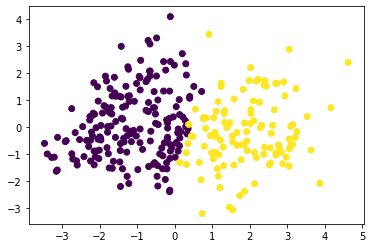

In [29]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=2, random_state=123)

# Fit model
%timeit kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)


# Plot the solution.
plt.scatter(pca[:,0], pca[:,1], c=y_pred)
plt.show()

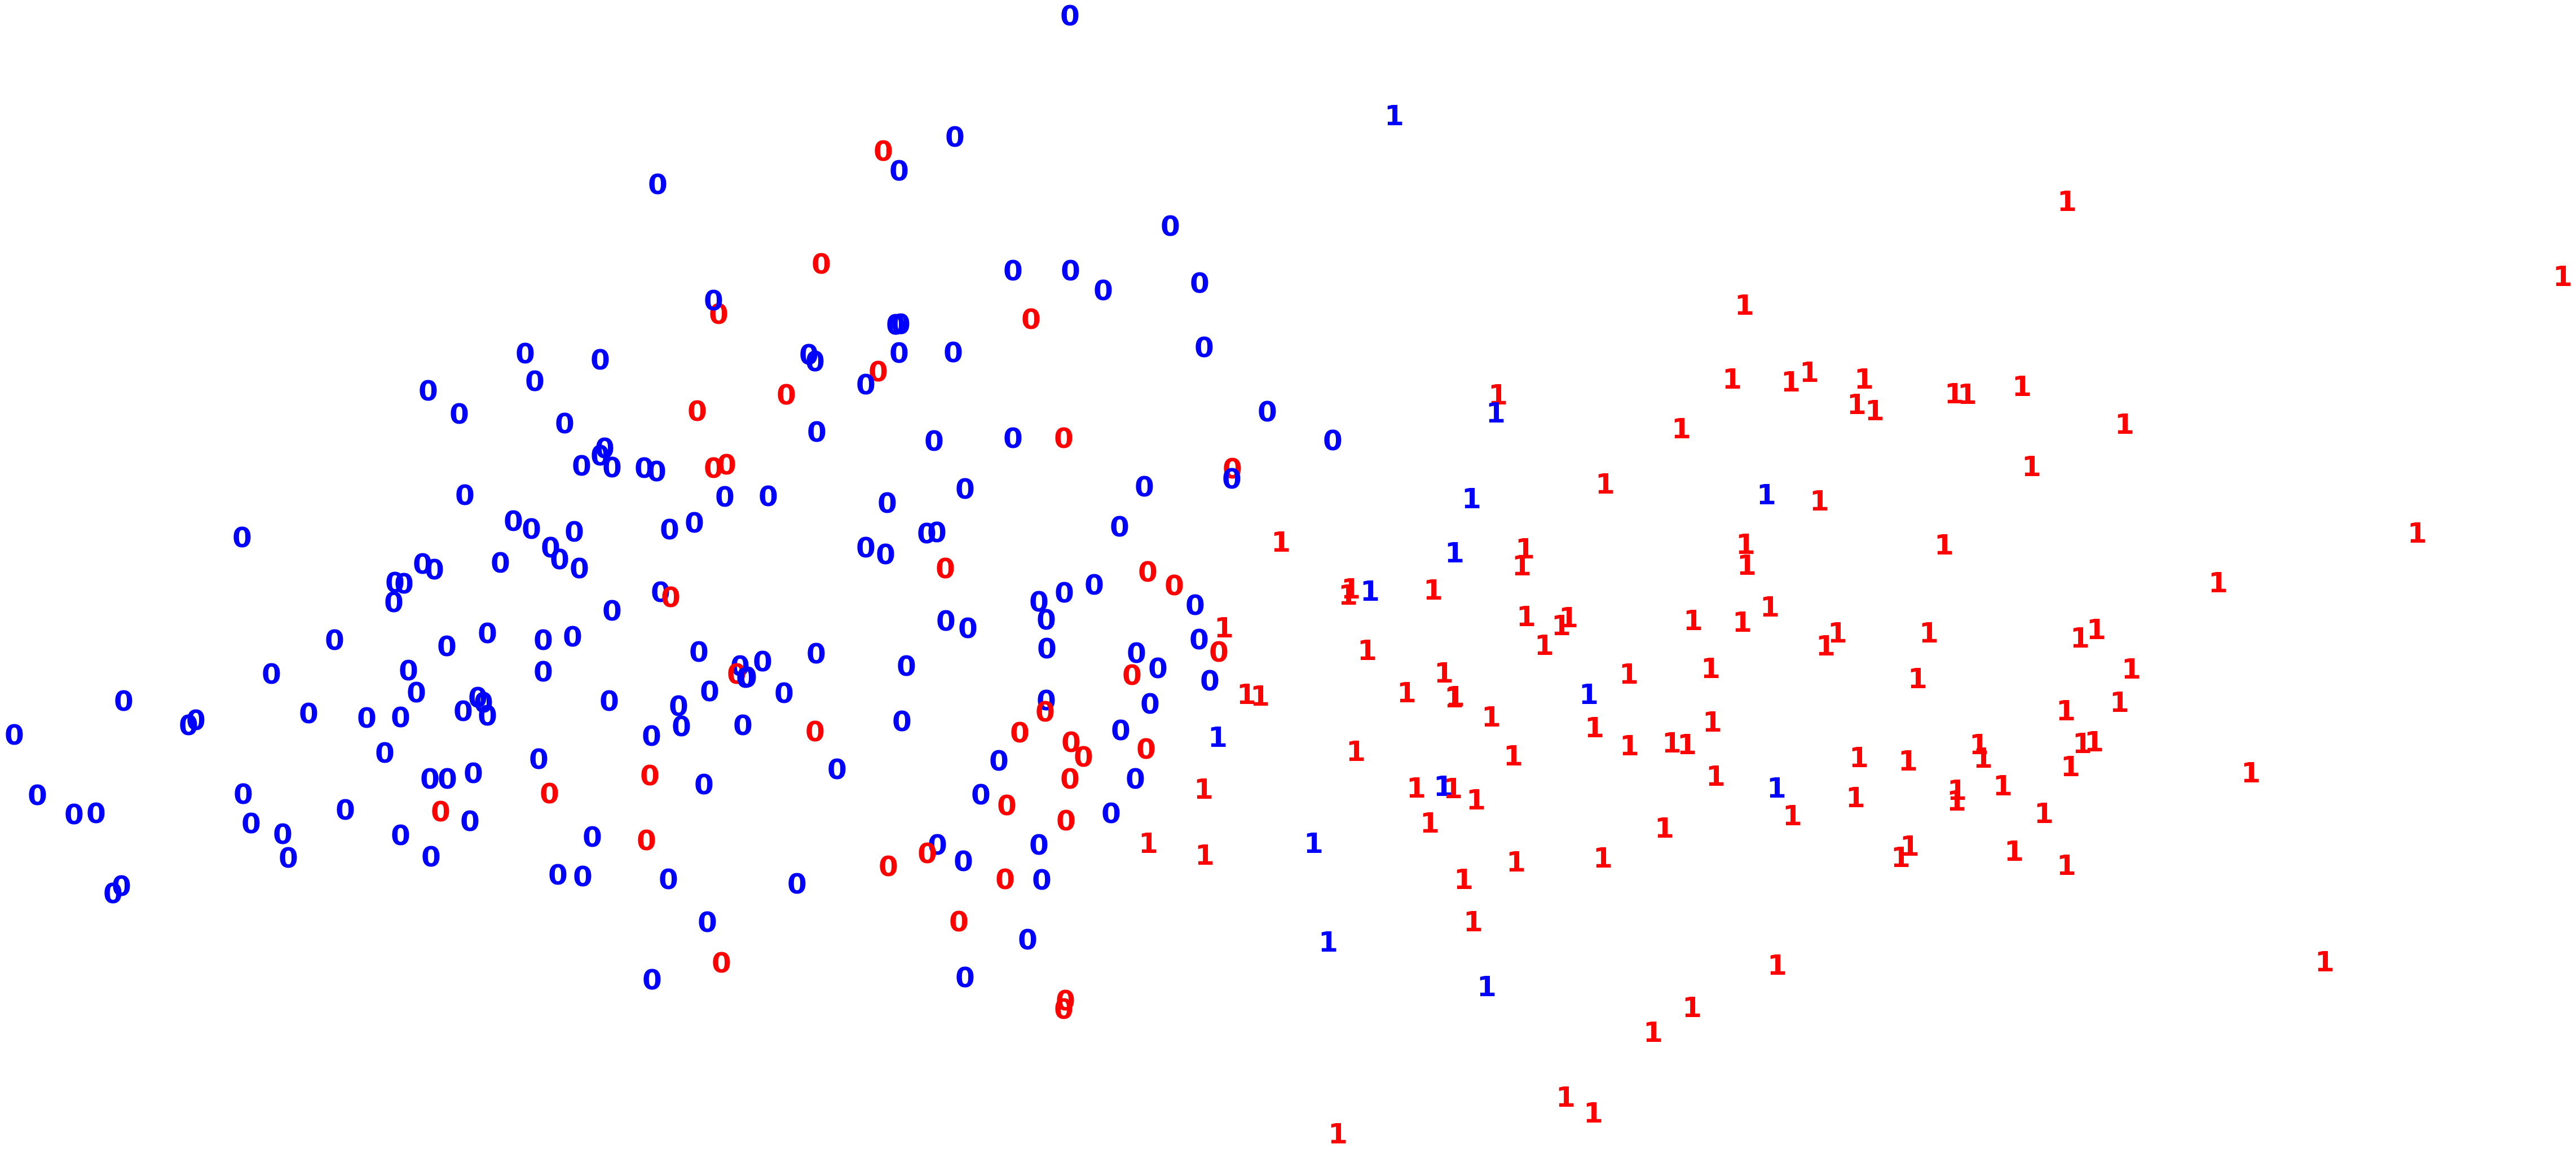

In [30]:
plt.figure(figsize=(10,5))
colours = 'rb'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


Yes it did as we expect it will do. It is separable to two different types 0 and 1. Few of them encounterd false positive or negative but lots of are predicted correctly.